In [1]:
!unzip -qq /content/drive/MyDrive/ImageCLEF/train.zip

In [ ]:
!pip install swifter

In [3]:
import re
import re
import html
import string
import swifter 
import pandas as pd 
import unicodedata
from nltk.tokenize import word_tokenize

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
df=pd.read_csv("//content/drive/MyDrive/ImageCLEF/ImageCLEFmedCaption_2022_caption_prediction_training_labels.csv", sep='\t')

In [6]:
df.head()

,ID,caption
0,ImageCLEFmedCaption_2022_train_000001,pericardial tamponade with clear distinction o...
1,ImageCLEFmedCaption_2022_train_000002,angiography of the aortic arch show delay visu...
2,ImageCLEFmedCaption_2022_train_000003,balloonocclude retrograde transvenous oblitera...
3,ImageCLEFmedCaption_2022_train_000004,film after glue embolization show no filling i...
4,ImageCLEFmedCaption_2022_train_000005,peripheral in posteroanterior projection angio...


In [7]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

#def addsequences(text):
  #return '' .join('startseq ' + " ".join([word for word in text.split() if len(word)>1]) + ' endseq')

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    return text
  
def normalize_corpus(corpus):
    return [normalize_text(t) for t in corpus]


 

In [8]:
df['clean_caption'] = df['caption'].swifter.apply(normalize_text)

#caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'


Pandas Apply:   0%|          | 0/83275 [00:00<?, ?it/s]

In [10]:

for index_label, row_series in df.iterrows():
  df.at[index_label , 'clean_caption'] = 'startseq ' + row_series['clean_caption'] + ' endseq'

In [11]:
df.head()

,ID,caption,clean_caption
0,ImageCLEFmedCaption_2022_train_000001,pericardial tamponade with clear distinction o...,startseq pericardial tamponade with clear dist...
1,ImageCLEFmedCaption_2022_train_000002,angiography of the aortic arch show delay visu...,startseq angiography of the aortic arch show d...
2,ImageCLEFmedCaption_2022_train_000003,balloonocclude retrograde transvenous oblitera...,startseq balloonocclude retrograde transvenous...
3,ImageCLEFmedCaption_2022_train_000004,film after glue embolization show no filling i...,startseq film after glue embolization show no ...
4,ImageCLEFmedCaption_2022_train_000005,peripheral in posteroanterior projection angio...,startseq peripheral in posteroanterior project...


In [12]:
all_captions = []
for index, row in df.iterrows():
  all_captions.append(row.clean_caption)

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

35490


In [14]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

393


In [15]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [16]:
# extract features from image
features = {}
directory = '/content/train'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/83275 [00:00<?, ?it/s]

In [17]:
# store features in pickle
WORKING_DIR='/content'
pickle.dump(features, open(os.path.join(WORKING_DIR, 'clef_features_vgg.pkl'), 'wb'))

In [18]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'clef_features_vgg.pkl'), 'rb') as f:
#with open(os.path.join('../input/picklesss/features.pkl'), 'rb') as f:    
    features = pickle.load(f)

In [19]:
df_use=df[['ID','clean_caption']].copy()

In [20]:
df_use.head()

,ID,clean_caption
0,ImageCLEFmedCaption_2022_train_000001,startseq pericardial tamponade with clear dist...
1,ImageCLEFmedCaption_2022_train_000002,startseq angiography of the aortic arch show d...
2,ImageCLEFmedCaption_2022_train_000003,startseq balloonocclude retrograde transvenous...
3,ImageCLEFmedCaption_2022_train_000004,startseq film after glue embolization show no ...
4,ImageCLEFmedCaption_2022_train_000005,startseq peripheral in posteroanterior project...


In [21]:
mapping=df_use.set_index('ID').T.to_dict('list')

In [ ]:
for key, value in mapping.items():
    print(key, ' : ', value)

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            feature_key = key.split('.')[0]
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    #print([key])
                    X1.append(features[feature_key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

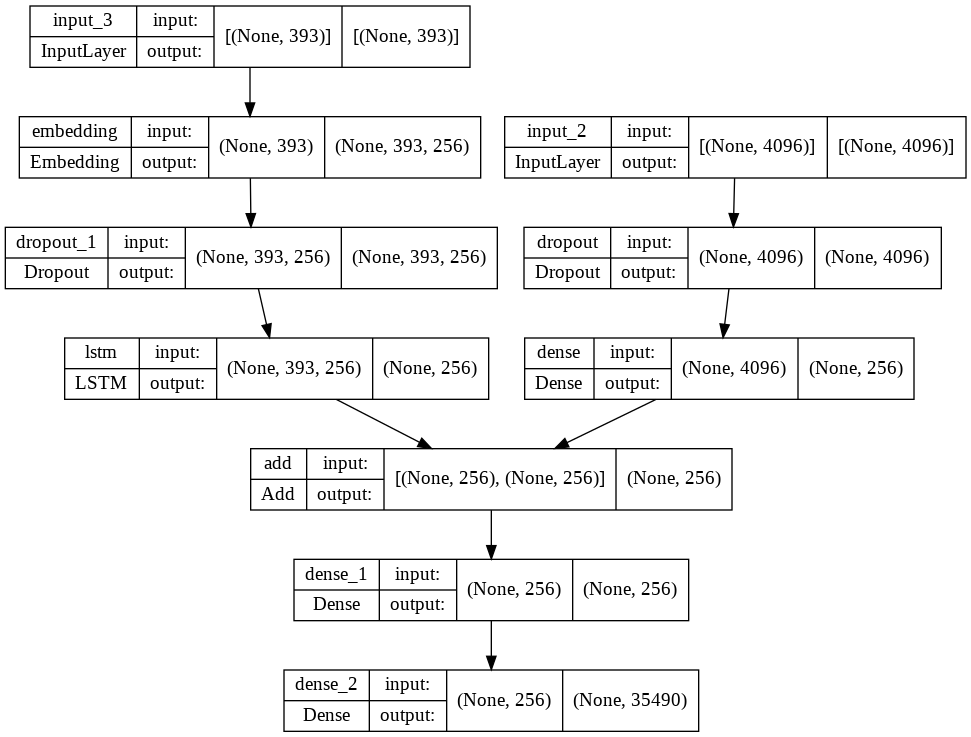

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["accuracy"])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for 10 epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
WORKING_DIR='./'
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    feature_key = key.split('.')[0]
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[feature_key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))